In [9]:
%run setup.py

from scipy.optimize import curve_fit
from grid import match_modes

In [27]:
# read in the stellar sample
stars = pd.read_excel('../sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & (~np.isin(stars['names'], ['ngc6819', 'ngc6791', 'binary']))
stars = stars.loc[idx,:].reset_index(drop=True)

modes = pd.read_excel('../sample/modes.xlsx')

# What are the systematic uncertainties for the models?
Look at the residuals of the best-fitting models

In [28]:
# eddin atmosphere
def multi(inputs):
    istar, star = inputs
    filepath = '../results_eddin_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]
    f = h5py.File(filepath,'r')

    idx = (modes['KIC']==star['KIC']) 
    tm = modes.loc[idx,:].reset_index(drop=True)
    
    idx = np.argmin(f['chi2_seismic_l0'][:])
    mod_freq = f['mod_freq_sc'][idx, (tm['l']==0).to_numpy()]
    obs_freq = tm.loc[tm['l']==0,'fc'].to_numpy()
    rms_l0 = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    return [rms_l0]

r=process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:,'rms_eddin'] = np.array(r)

# hopf atmosphere
def multi(inputs):
    istar, star = inputs
    filepath = '../results_hopf_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]
    f = h5py.File(filepath,'r')

    idx = (modes['KIC']==star['KIC']) 
    tm = modes.loc[idx,:].reset_index(drop=True)
    
    idx = np.argmin(f['chi2_seismic_l0'][:])
    mod_freq = f['mod_freq_sc'][idx, (tm['l']==0).to_numpy()]
    obs_freq = tm.loc[tm['l']==0,'fc'].to_numpy()
    rms_l0 = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    return [rms_l0]

r=process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:,'rms_hopf'] = np.array(r)

  0%|          | 0/1249 [00:00<?, ?it/s]

  0%|          | 0/1249 [00:00<?, ?it/s]

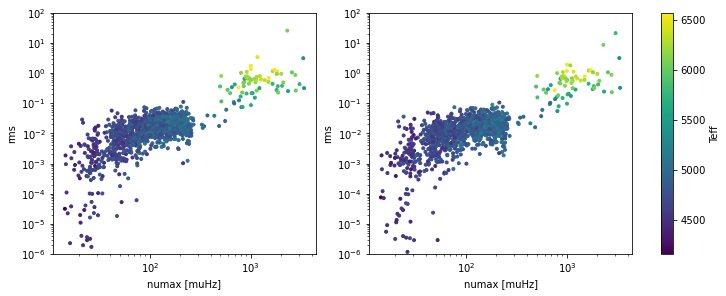

In [29]:
fig, axes = plt.subplots(figsize=[10,4], nrows=1, ncols=2, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

c=axes[0].scatter(stars['numax'], stars['rms_eddin'], marker='.', c=stars['Teff'])
c=axes[1].scatter(stars['numax'], stars['rms_hopf'], marker='.', c=stars['Teff'])

for iax in range(len(axes)):
    axes[iax].set_yscale('log')
    axes[iax].set_xscale('log')
    axes[iax].set_xlabel('numax [muHz]')
    axes[iax].set_ylim(10.**-6, 10.**2)
    axes[iax].set_ylabel('rms')
plt.colorbar(c, ax=axes).set_label('Teff')

$\sigma_{\rm mod}$ = 1.3041 * (numax/3090)^1.2330 * (Teff/5777)^3.1870
$\sigma_{\rm mod}$ = 1.2286 * (numax/3090)^1.1951 * (Teff/5777)^3.6207


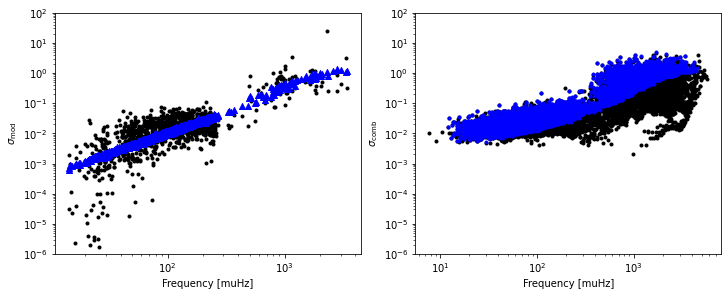

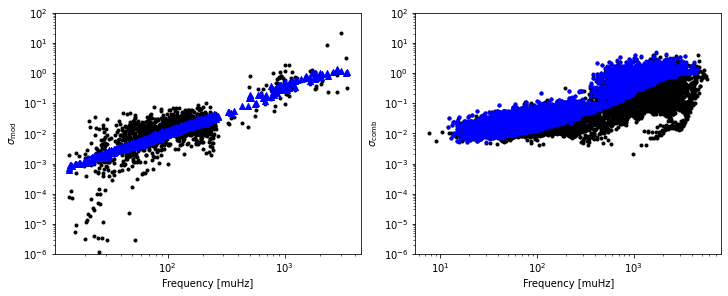

In [30]:
for atm in ['_eddin', '_hopf']:
    def func_sig_sys(xdata, loga, b, c):
        # the functional form is sig_mod = a * (numax)**b
        # here we fit log(sig_mod) = loga + b * log(numax)
        return loga + xdata[:,0] * b + xdata[:,1] * c

    idx = stars[['rms'+atm, 'numax', 'Teff']].notna().sum(axis=1) == 3

    xdata = stars.loc[idx,['numax', 'Teff']].to_numpy()
    xdata[:,0] = np.log10(xdata[:,0]/3090)
    xdata[:,1] = np.log10(xdata[:,1]/5777)
    ydata = np.log10(stars.loc[idx,'rms'+atm]).to_numpy()

    popt, pcov = curve_fit(func_sig_sys, xdata, ydata)
    ymodel = func_sig_sys(xdata, *popt)

    stars.loc[idx,'rmsp'+atm] = 10.0**popt[0] * (stars.loc[idx,'numax']/3090)**popt[1] * (stars.loc[idx,'Teff']/5777)**popt[2]
    
    modes = modes.merge(stars[['KIC', 'rmsp'+atm]], how='left', on='KIC')
    
    fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=2, squeeze=False, constrained_layout=True)
    axes=axes.reshape(-1)

    idx = stars[['rms'+atm, 'numax', 'Teff']].notna().sum(axis=1) == 3

    axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rms'+atm], marker='.', c='k')
    axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rmsp'+atm], marker='^', c='b')

    modes['e_fc_comb'+atm] = np.sqrt(modes['e_fc']**2.0 + modes['rmsp'+atm]**2.0)
    axes[1].scatter(modes['fc'], modes['e_fc'], marker='.', c='k')
    axes[1].scatter(modes['fc'], modes['e_fc_comb'+atm], marker='.', c='b')

    axes[0].set_ylabel('$\\sigma_{\\rm mod}$')
    axes[1].set_ylabel('$\\sigma_{\\rm comb}$')

    for iax in range(2):
        axes[iax].set_yscale('log')
        axes[iax].set_xscale('log')
        axes[iax].set_ylim(10**-6, 10**2)
        axes[iax].set_xlabel('Frequency [muHz]')

    print('$\sigma_{\\rm mod}$'+' = {:0.4f} * (numax/3090)^{:0.4f} * (Teff/5777)^{:0.4f}'.format(10.0**popt[0], *popt[1:]))

# Create data for the optimization of stellar surface parameters


In [31]:
# load in all models first
atm = '_hopf' # 'eddin'
files = ['../models/uncalibrated{}/'.format(atm)+f for f in os.listdir('../models/uncalibrated{}/'.format(atm)) if f.endswith('.npy')]
models = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True)) for file in files], ignore_index=True)

In [32]:
# set index to enable fast lookup
models = models.set_index(['index', 'profile_number'])

In [33]:
models.head()

flag_seismo      star_age  star_mass  luminosity  \
index profile_number                                                     
0     1.0                       1  4.365915e+07    0.77866    0.420676   
      2.0                       1  4.517960e+07    0.77866    0.416821   
      3.0                       1  4.700415e+07    0.77866    0.414893   
      4.0                       1  4.919361e+07    0.77866    0.414474   
      5.0                       1  5.497377e+07    0.77866    0.415199   

                        radius         Teff  delta_nu_scaling  numax_scaling  \
index profile_number                                                           
0     1.0             0.729152  5443.827089        191.470583    4661.965681   
      2.0             0.727497  5437.491239        192.124491    4685.934084   
      3.0             0.726936  5433.285112        192.346769    4694.980218   
      4.0             0.727180  5431.000512        192.249991    4692.817524   
      5.0             0.728589  5428.119024        191.692565    4675.924561   

                      acoustic_cutoff  delta_Pg  ...        numax         Dnu  \
index profile_number                             ...                            
0     1.0                 4661.965681       0.0  ...  4661.965681  191.470583   
      2.0                 4685.934084       0.0  ...  4685.934084  192.124491   
      3.0                 4694.980218       0.0  ...  4694.980218  192.346769   
      4.0                 4692.817524       0.0  ...  4692.817524  192.249991   
      5.0                 4675.924561       0.0  ...  4675.924561  191.692565   

                         [M/H]  \
index profile_number             
0     1.0            -0.419028   
      2.0            -0.419028   
      3.0            -0.419028   
      4.0            -0.419028   
      5.0            -0.419028   

                                                                 mode_l  \
index profile_number                                                      
0     1.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      2.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      3.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      4.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      5.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                 mode_n  \
index profile_number                                                      
0     1.0             [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....   
      2.0             [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....   
      3.0             [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....   
      4.0             [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....   
      5.0             [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....   

                                                            mode_freq_o  \
index profile_number                                                      
0     1.0             [2375.079316414857, 2568.331287871081, 2759.17...   
      2.0             [2383.42398797886, 2577.388927541867, 2768.922...   
      3.0             [2386.338345894505, 2580.55377197823, 2772.330...   
      4.0             [2385.216775537427, 2579.330697661297, 2771.02...   
      5.0             [2378.385981583663, 2571.902697799438, 2763.05...   

                                                           mode_inertia  \
index profile_number                                                      
0     1.0             [3.075825668083636e-07, 1.617433470671002e-07,...   
      2.0             [3.129673068436738e-07, 1.644365096654005e-07,...   
      3.0             [3.160165563501344e-07, 1.659733267964953e-07,...   
      4.0             [3.171175064570504e-07, 1.665510645317484e-07,...   
      5.0             [3.173869458037739e-07, 1.667539174621528e-07,...   

                      Dnu_freq_

In [34]:
# a, b, c = [1.3041, 1.2330, 3.1870] #eddin
a, b, c = [1.2286, 1.1951, 3.6207] #hopf

In [38]:
# gather the data into a gigantic array

Nmodels_max = 1500

def multi(inputs):
    istar, star = inputs

    filepath = '../results{}_spec_gaia_nu/{:0.0f}/data.h5'.format(atm, star['KIC'])
    if not os.path.exists(filepath): return None

    # observations
    idx = (modes['KIC']==star['KIC']) & (modes['l']==0)
    Nmodes = np.sum(idx)
    obs_freq = np.array(modes.loc[idx, 'fc'])
    obs_efreq = np.array(modes.loc[idx, 'e_fc']) 
    obs_l = np.array(modes.loc[idx, 'l']) 

    mod_efreq_sys = a * (star['numax']/3090)**b * (star['Teff']/5777)**c
    
    # models
    data = h5py.File(filepath, 'r')

    idx = (data['surf_corr_at_numax'][:]<0) & (np.abs(data['Dnu_freq'][:]/star['Dnu']-1)<0.15) \
             & (np.abs(data['numax_scaling'][:]/star['numax']-1)<0.15) & (data['surf_a3'][:]<0) 

    if np.sum(idx) < 30: return None
    # begin reduced selection
    if np.sum(idx) > Nmodels_max:
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx], Nmodels_max/np.sum(idx)*100))
    else:
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx], 100))
    idx = uidx
    # end reduced selection

    Nmodels = np.sum(idx)
    g = data['star_mass'][idx]/data['radius'][idx]**2.0
    Teff = data['Teff'][idx]
    feh = data['FeH'][idx]
    chi2_nonseis = data['chi2_classical'][idx]
    chi2 = data['chi2'][idx]

    numax_scaling = data['numax_scaling'][idx]
    numax_obs = np.zeros(np.sum(idx))+star['numax']

    Dnu_freq = data['Dnu_freq'][idx]

    Yinit = data['Yinit'][idx] 
    amlt = data['amlt'][idx]
    fov_core = data['fov_core'][idx] 
    fov_shell = data['fov_shell'][idx]
    
    mod_freqs = np.zeros((Nmodels, Nmodes))
    mod_inertias = np.zeros((Nmodels, Nmodes))
    
    indices = data['index'][idx]
    profiles = data['profile_number'][idx]

    for imod in range(Nmodels):
        if (indices[imod], profiles[imod]) in models.index :
            model = models.loc[(indices[imod], profiles[imod])]

            mod_freq = model['mode_freq_o']
            mod_l = model['mode_l']
            mod_inertia = model['mode_inertia']

            _, _, _, mode_freq_matched, mode_l_matched, mode_inertia_matched = match_modes(obs_freq, obs_efreq, obs_l, mod_freq, mod_l, mod_inertia)

            mod_freqs[imod, :] = mode_freq_matched
            mod_inertias[imod, :] = mode_inertia_matched
    
    idx = mod_freqs[:, 0] != 0
    Nmodels = np.sum(idx)
    
    # print('Processing KIC {:09.0f}, Nmodel: {:0.0f}'.format(star['KIC'], np.sum(idx)))

    datacube = {'istar':istar, 'KIC':star['KIC'], 'Nmodels':Nmodels, 
                'Nmodes':Nmodes, 'mod_efreq_sys':mod_efreq_sys,
                'obs_freq':obs_freq, 'obs_efreq':obs_efreq,
                'g':g[idx], 'Teff':Teff[idx], 'feh':feh[idx], 'chi2_nonseis':chi2_nonseis[idx], 'chi2':chi2[idx],
                'numax_obs':numax_obs[idx], 'numax_scaling':numax_scaling[idx], 
                'Dnu_freq':Dnu_freq[idx], 
                'Yinit':Yinit[idx], 'amlt':amlt[idx], 'fov_core':fov_core[idx], 'fov_shell':fov_shell[idx],
                'mod_freqs':mod_freqs[idx,:], 'mod_inertias':mod_inertias[idx,:]}
    return datacube 

sel = ~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary'])
r=process_map(multi, stars.loc[sel,:].iterrows(), total=np.sum(sel), max_workers=16)
r = np.array(r, dtype=object) 
data_to_save = r[~(r == None)]

np.save('../data/stellar_models_for_surface_optimisation{}'.format(atm), data_to_save)

  0%|          | 0/1239 [00:00<?, ?it/s]

In [40]:
stardata = np.load('../data/stellar_models_for_surface_optimisation{}.npy'.format(atm), allow_pickle=True)

(7000.0, 4000.0)

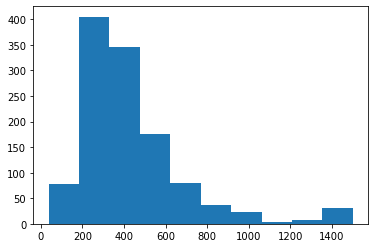

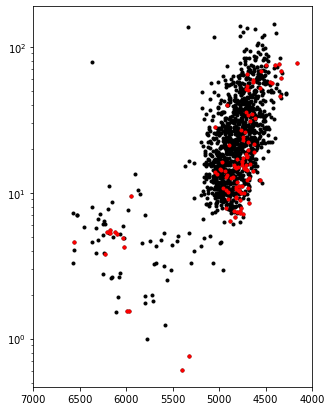

In [44]:
Nmodels_star = np.array([stardata[istar]['Nmodels'] for istar in range(len(stardata))])
kics = np.array([stardata[istar]['KIC'] for istar in range(len(stardata))])
plt.hist(Nmodels_star)

plt.figure(figsize=(5,7))
plt.plot(stars['Teff'], stars['lum_J'], 'k.')
idx = np.isin(stars['KIC'], kics[Nmodels_star < 200])
plt.plot(stars.loc[idx,'Teff'], stars.loc[idx,'lum_J'], 'r.')
plt.yscale('log')
plt.xlim(7000, 4000)